Required Libraries

In [1]:
#Data Pre-processing packages
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
#Data Visualization Libraries
import seaborn as sns
sns.set(rc={'figure.figsize': (10,6)})
custom_colors = ['#78579a','#f1b032','#8fce00']

#matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

#colorama
!pip install colorama
from colorama import Fore, Back,Style
y_ =Fore.CYAN
m_ =Fore.RED

#time series analysis packages
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Facebook Prohet Packages
# !pip install prophet
# !pip install fbprophet
from prophet import Prophet
from prophet.diagnostics  import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric


In [4]:
data = pd.read_csv('Ethereum Historical Data.csv')

Dataset Overview

In [5]:
print(f'{m_}Total Records:{y_}{data.shape}\n')
print(f'{m_}DataTypes of data columns: \n{y_}{data.dtypes}')

Total Records:(2352, 6)

DataTypes of data columns: 
Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2352 non-null   object 
 1   Open    2352 non-null   float64
 2   High    2352 non-null   float64
 3   Low     2352 non-null   float64
 4   Close   2352 non-null   float64
 5   Volume  2352 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 110.4+ KB


In [7]:
data.head(10)

,Date,Open,High,Low,Close,Volume
0,2016-03-10,11.20,11.85,11.07,11.75,4
1,2016-03-11,11.75,11.95,11.75,11.95,179
2,2016-03-12,11.95,13.45,11.95,12.92,833
3,2016-03-13,12.92,15.07,12.92,15.07,1295
4,2016-03-14,15.07,15.07,11.40,12.50,92183
5,2016-03-15,12.63,13.42,11.98,13.06,39725
6,2016-03-16,13.06,13.89,12.62,12.88,19240
7,2016-03-17,12.58,12.61,10.44,10.74,89450
8,2016-03-18,11.09,11.20,8.34,10.74,157374
9,2016-03-19,10.97,11.10,9.78,10.31,67547


In [8]:
#converting of the date column to datetime format and sorting the values by date
data['Date']=pd.to_datetime(data['Date'], infer_datetime_format=True, format='%y-%m-%d')
data.sort_values(by='Date',inplace=True)
data.rename(columns={'Close':'Price'}, inplace=True)
data.tail()

,Date,Open,High,Low,Price,Volume
2347,2022-08-13,1957.62,2018.97,1946.65,1983.50,798084
2348,2022-08-14,1983.52,2028.40,1909.19,1935.10,662149
2349,2022-08-15,1935.10,2012.02,1873.70,1900.25,1091386
2350,2022-08-16,1900.08,1914.06,1856.44,1876.70,725776
2351,2022-08-17,1876.69,1904.36,1875.15,1894.68,730127


In [9]:
missed = pd.DataFrame()
missed['column'] = data.columns

missed['percent'] = [round(100*data[col].isnull().sum()/len(data), 2) for col in data.columns]
missed.sort_values('percent', ascending=False, inplace=True)
missed
#no missing values

,column,percent
0,Date,0.0
1,Open,0.0
2,High,0.0
3,Low,0.0
4,Price,0.0
5,Volume,0.0


In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Feature Distribution

In [11]:
#visualizing distribution of key variables like opening price, closing price and change in
#Eth

def triple_plot(x,title, c):
  fig, ax = plt.subplots(3,1, figsize=(20,10), sharex=True)
  sns.distplot(x, ax=ax[0], color=c)
  ax[0].set(xlabel=None)
  ax[0].set_title('Histogram + KDE')
  sns.boxplot(x, ax=ax[1], color=c)
  ax[1].set(xlabel=None)
  ax[1].set_title('Boxplot')
  sns.violinplot(x, ax=ax[2], color=c)
  ax[2].set(xlabel=None)
  ax[2].set_title('Violin Plot')
  fig.suptitle(title, fontsize=26)
  plt.tight_layout(pad=3.0)
  plt.show()


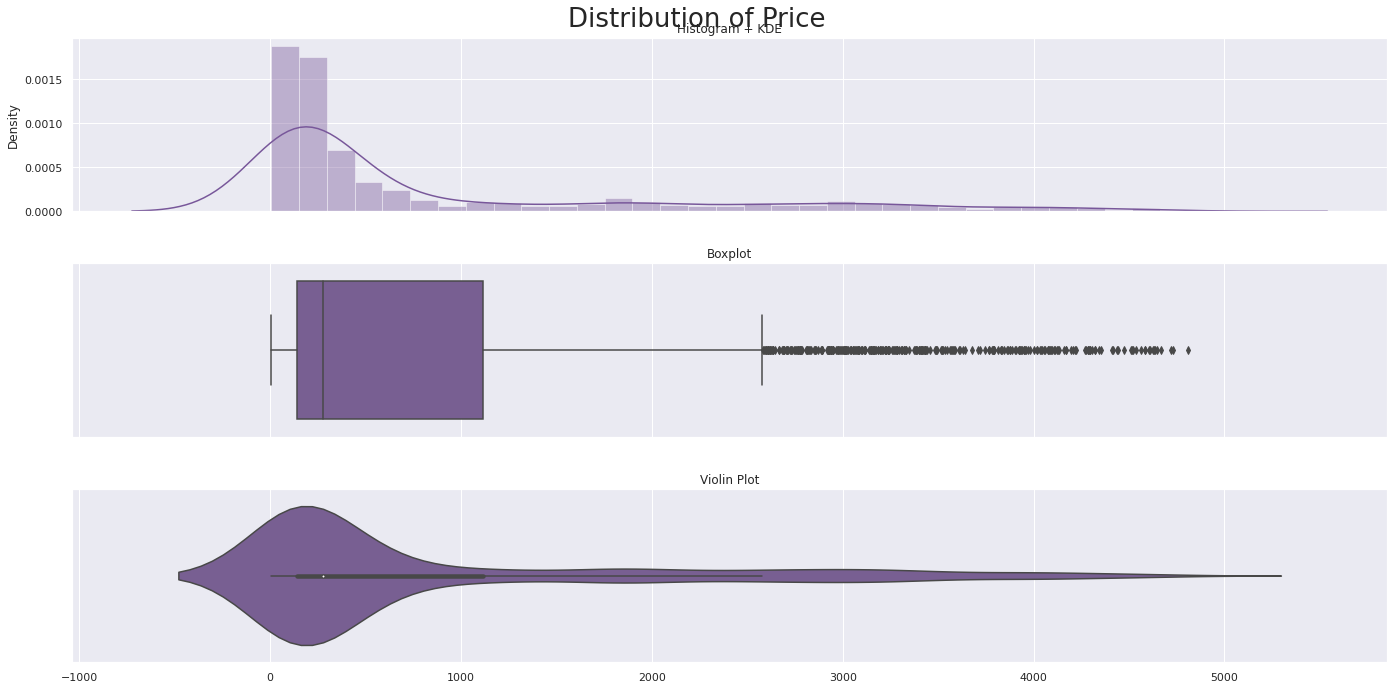

In [12]:
triple_plot(data['Price'], 'Distribution of Price', custom_colors[0])

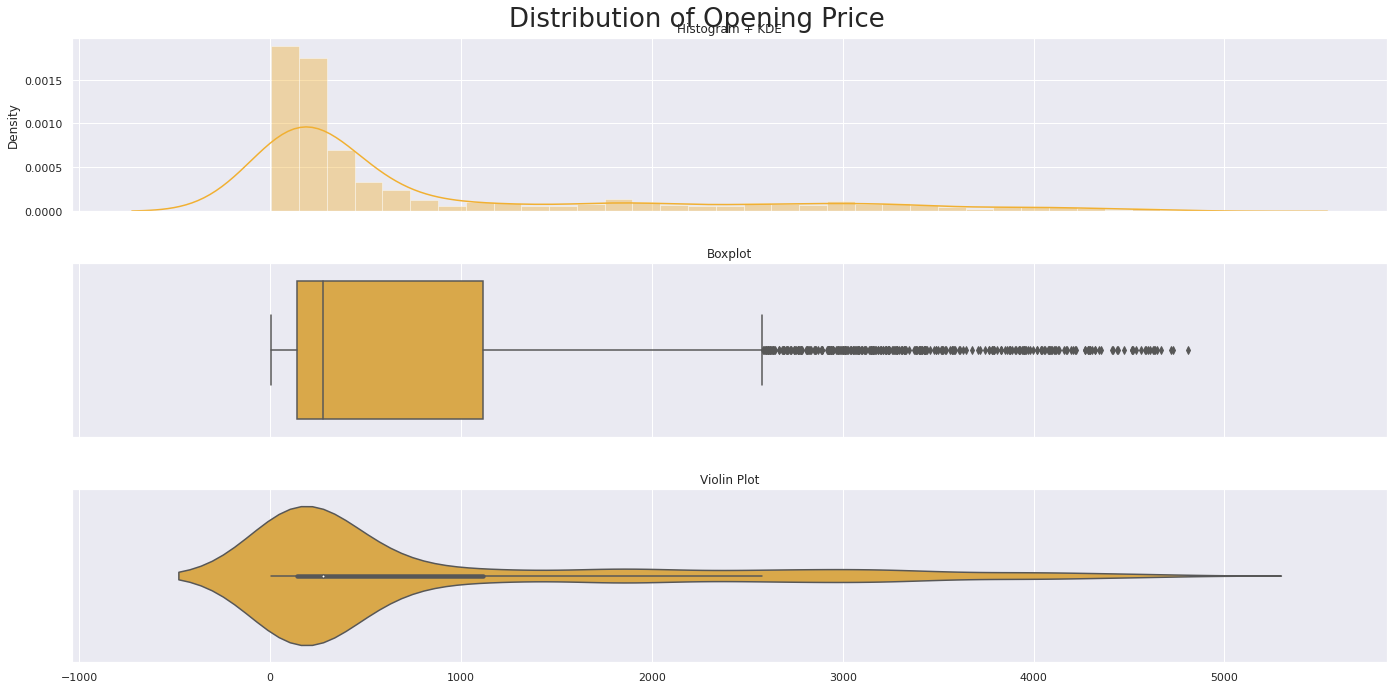

In [13]:
triple_plot(data['Open'], 'Distribution of Opening Price', custom_colors[1])

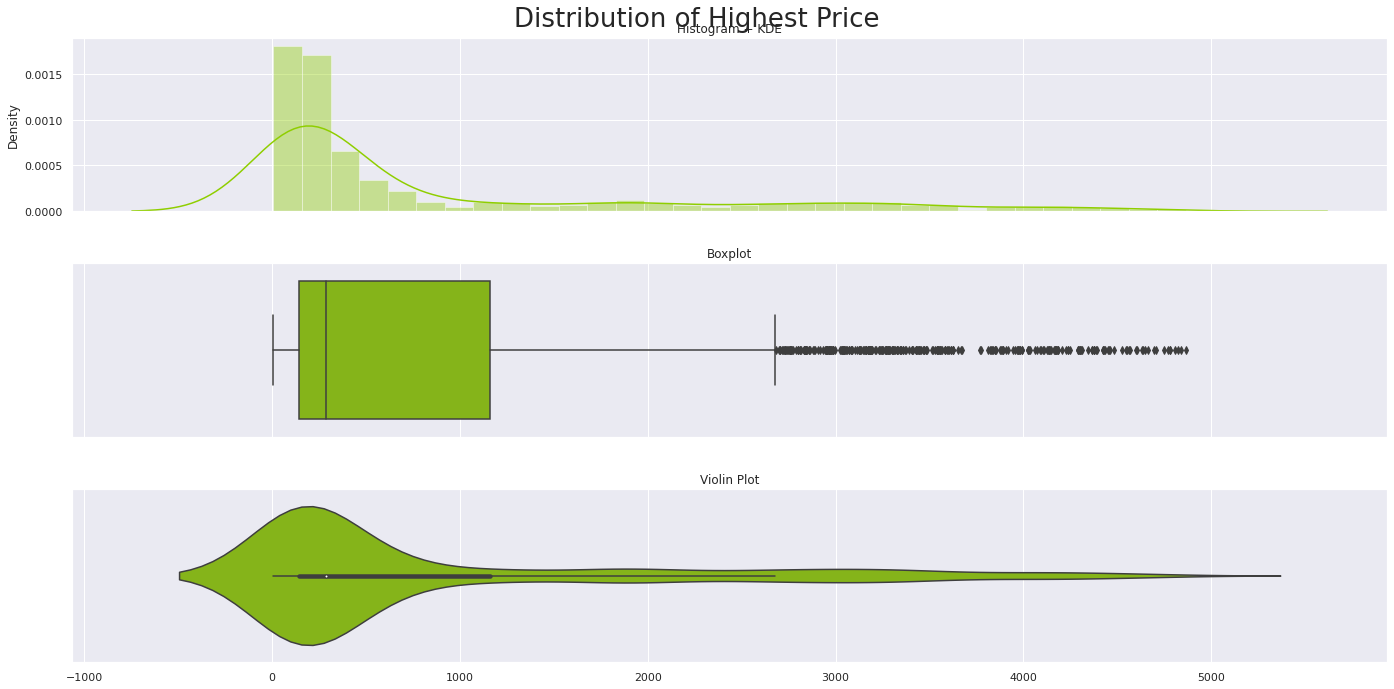

In [14]:
triple_plot(data["High"], 'Distribution of Highest Price', custom_colors[2])

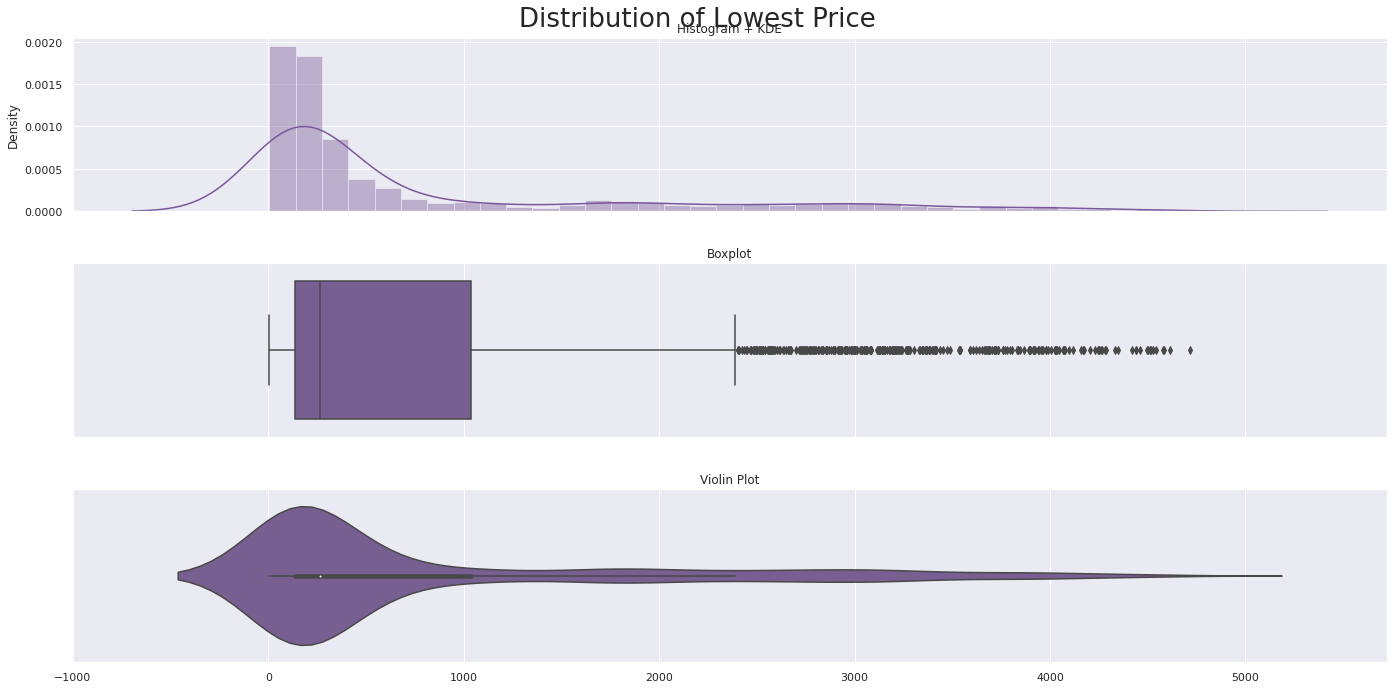

In [15]:
triple_plot(data['Low'], 'Distribution of Lowest Price', custom_colors[0])

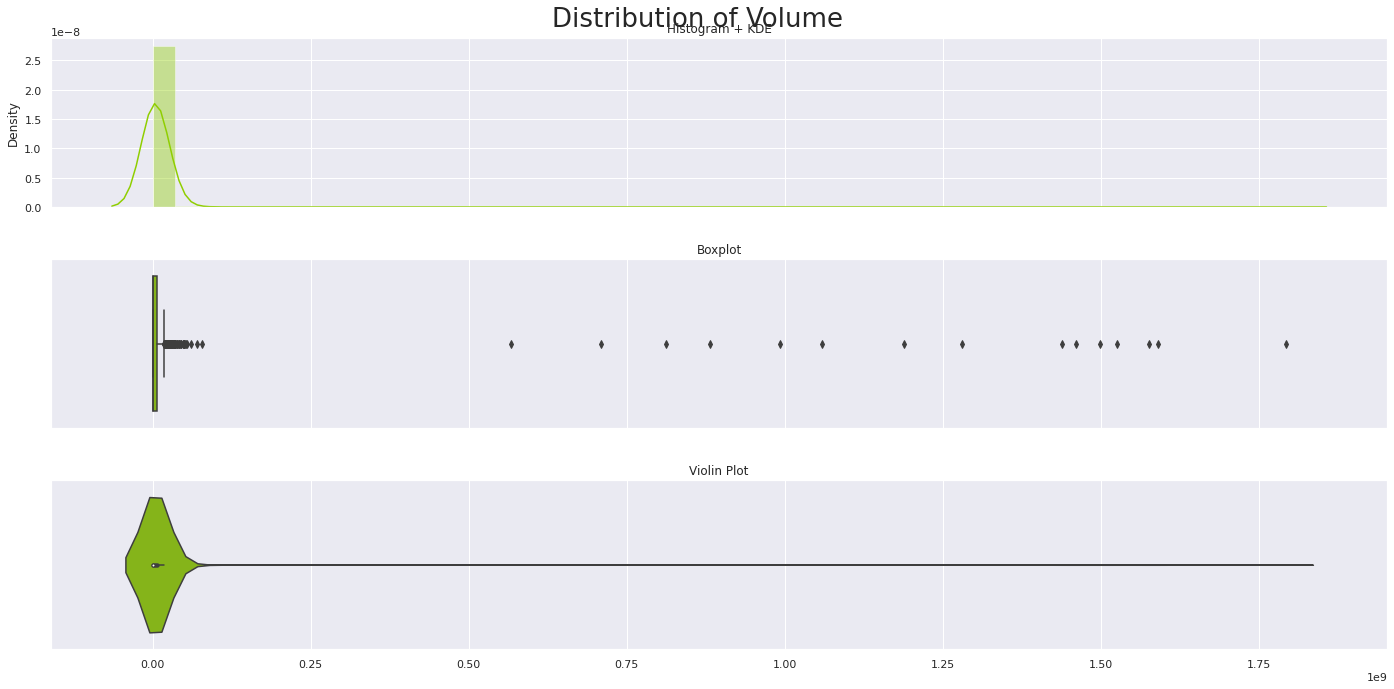

In [16]:
triple_plot(data['Volume'], 'Distribution of Volume', custom_colors[2])

Correlation Analysis

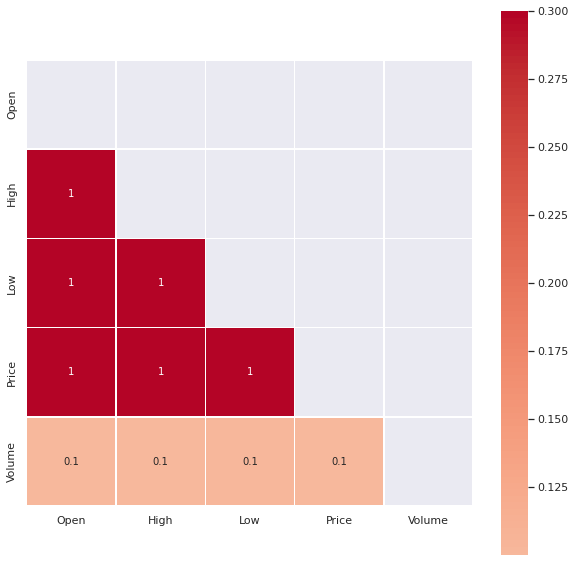

In [17]:
plt.figure(figsize=(10,10))
corr = data[data.columns[1:]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=0.3, center=0,
            square=True, linewidths=.5, annot=True,)
plt.show()

Time Series Analysis and Prediction using Prophet

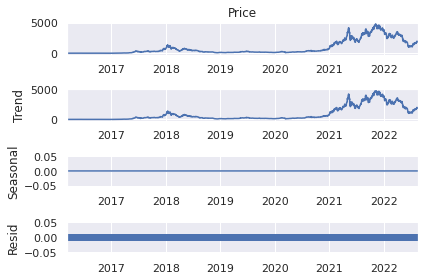

<Figure size 1440x1080 with 0 Axes>

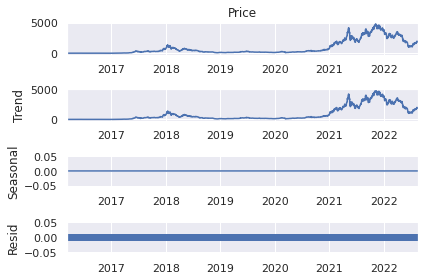

In [18]:
plt.figure(figsize=(20,15))
series = data[['Date','Price']]
series.set_index('Date', inplace=True)
srs = series['Price']
result = seasonal_decompose(srs, model='additive',freq=1)
result.plot()

In [19]:
#preparing input into Prophet
prophet_df = data[['Date','Price']]
prophet_df.rename(columns = {'Date':'ds',"Price":'y'}, inplace=True)
prophet_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ds,y
0,2016-03-10,11.75
1,2016-03-11,11.95
2,2016-03-12,12.92
3,2016-03-13,15.07
4,2016-03-14,12.50


In [ ]:
#creating and fitting the prophet model with default values
prophet_basic = Prophet()
prophet_basic.fit(prophet_df[['ds','y']])


Predicting Future Values

In [21]:
#Extending 1 year(365 days) into the future
future = prophet_basic.make_future_dataframe(periods=365, freq='D')
future.tail(5)

,ds
2712,2023-08-13
2713,2023-08-14
2714,2023-08-15
2715,2023-08-16
2716,2023-08-17


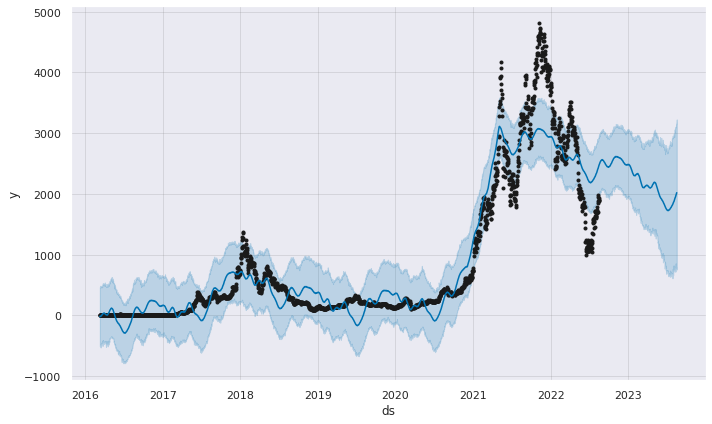

In [22]:
#prediction and plotting of predicted data
forecast = prophet_basic.predict(future)
pred_fig = prophet_basic.plot(forecast)

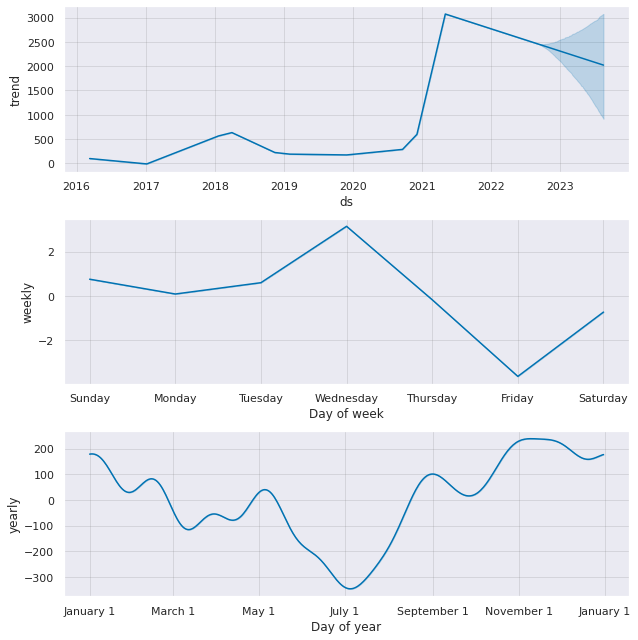

In [23]:
#plotting forecasted components: Trends and Seasonality
comp_fig = prophet_basic.plot_components(forecast)

Adding of Changepoints to Prophet Prediction

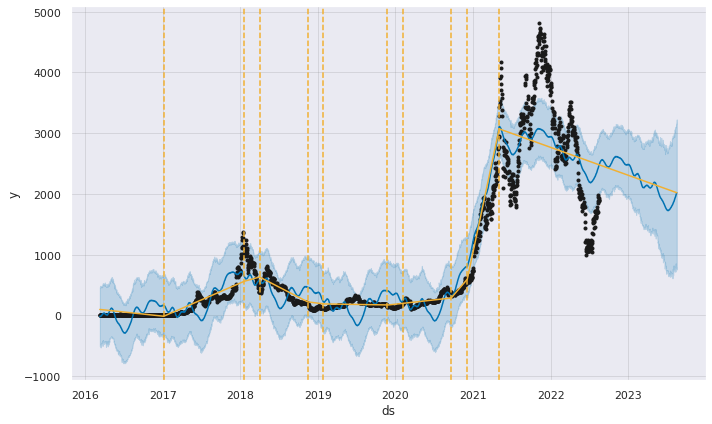

In [24]:
#Changepoints: points of abrupt changes in the time-series trajectory
pred_fig = prophet_basic.plot(forecast)
cp_ = add_changepoints_to_plot(pred_fig.gca(), prophet_basic, forecast, cp_color ='#f1b032')

In [25]:
print(f'{m_}ChangePoints:\n {y_}{prophet_basic.changepoints}\n')

ChangePoints:
 75     2016-05-24
150    2016-08-07
226    2016-10-22
301    2017-01-05
376    2017-03-21
451    2017-06-04
526    2017-08-18
602    2017-11-02
677    2018-01-16
752    2018-04-01
827    2018-06-15
902    2018-08-29
978    2018-11-13
1053   2019-01-27
1128   2019-04-12
1203   2019-06-26
1278   2019-09-09
1354   2019-11-24
1429   2020-02-07
1504   2020-04-22
1579   2020-07-06
1654   2020-09-19
1730   2020-12-04
1805   2021-02-17
1880   2021-05-03
Name: ds, dtype: datetime64[ns]



Adding Multiple Regressors to the Prophet Model

In [ ]:
prophet_df['Open'] = data['Open']
prophet_df['High'] = data['High']
prophet_df['Volume'] = data['Volume']
prophet_df['Low'] = data['Low']

#creating training and test sets
prophet_df = prophet_df.dropna()
train_X = prophet_df[:round(0.8*len(prophet_df))]
test_X = prophet_df[round(0.8*len(prophet_df)):]

In [27]:
pro_regressor = Prophet()
pro_regressor.add_regressor('Open')
pro_regressor.add_regressor('High')
pro_regressor.add_regressor('Low')
pro_regressor.add_regressor('Volume')

In [28]:
#fitting the data
pro_regressor.fit(train_X)
future_data = pro_regressor.make_future_dataframe(periods=365,freq='D')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv5va56f/xip208vu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnv5va56f/eq6f8c8p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10263', 'data', 'file=/tmp/tmpnv5va56f/xip208vu.json', 'init=/tmp/tmpnv5va56f/eq6f8c8p.json', 'output', 'file=/tmp/tmp2tyxfwg0/prophet_model-20220831135248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:52:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:52:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


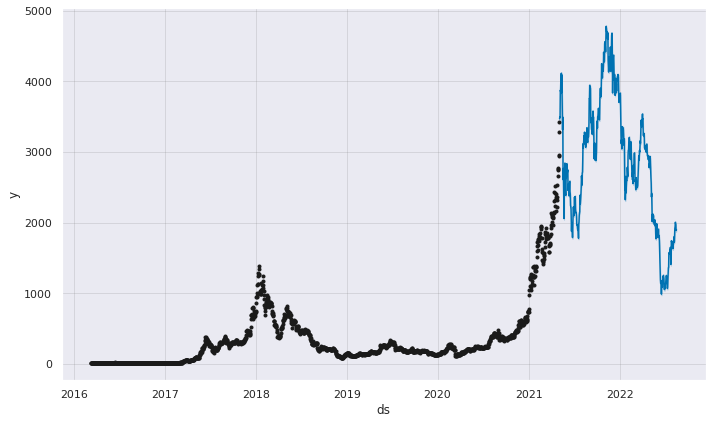

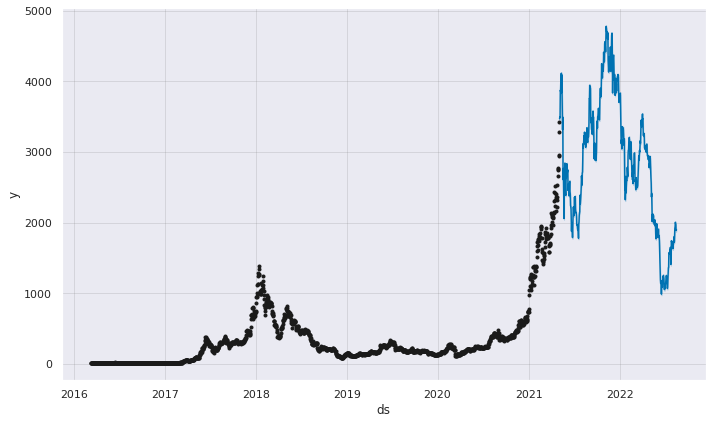

In [29]:
#predicting against the test set
forecast_data = pro_regressor.predict(test_X)
pro_regressor.plot(forecast_data)

Cross Validation and Running Performance Tests on the Model

In [ ]:
#Using the first 700 days as training data; as the first cutoff 
#cross validating using half-year sets for every alternate 90-day period
df_cv = cross_validation(pro_regressor,initial='700 days', period='90 days', horizon='180 days')


In [31]:
df_cv.head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-02-20,917.670964,904.172078,929.915688,884.51,2018-02-19
1,2018-02-21,864.391604,851.227758,877.919848,839.10,2018-02-19
2,2018-02-22,844.133709,831.429375,856.633719,803.66,2018-02-19
3,2018-02-23,868.475315,855.313577,881.226173,856.65,2018-02-19
4,2018-02-24,846.779722,834.861950,859.366550,834.36,2018-02-19
5,2018-02-25,838.345536,825.697333,851.449233,840.88,2018-02-19
6,2018-02-26,869.728524,856.885807,881.319422,866.99,2018-02-19
7,2018-02-27,887.347471,874.516745,900.347614,871.44,2018-02-19
8,2018-02-28,873.458558,859.752413,886.651648,852.49,2018-02-19
9,2018-03-01,871.474086,858.975003,884.491154,870.04,2018-02-19


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,18 days,76.103582,8.723737,5.507026,0.018940,0.012451,0.018838,0.902778
1,19 days,80.494295,8.971861,5.568098,0.019122,0.012369,0.019028,0.902778
2,20 days,75.823863,8.707690,5.382148,0.018837,0.012369,0.018739,0.916667
3,21 days,71.559074,8.459260,5.390690,0.019395,0.013439,0.019316,0.916667
4,22 days,71.150363,8.435067,5.349998,0.019159,0.013634,0.019076,0.921296


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
158,176 days,671.987480,25.922721,13.472698,0.029617,0.023482,0.029443,0.740741
159,177 days,676.649571,26.012489,13.445898,0.029663,0.022629,0.029429,0.745370
160,178 days,689.380607,26.256058,13.612430,0.029766,0.022171,0.029523,0.750000
161,179 days,703.608147,26.525613,13.756422,0.030226,0.021360,0.030102,0.750000
162,180 days,728.582098,26.992260,14.104161,0.031433,0.021018,0.031578,0.745370


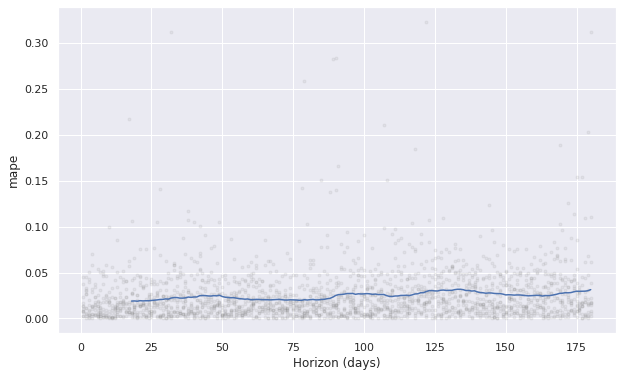

In [32]:
pm =performance_metrics(df_cv, rolling_window=0.1)
display(pm.head(), pm.tail())

#plotting mape to see if it falls below the .05 threshold
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.1)
plt.show()